### Geometric Brownian Motion Paths

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
import scipy.stats as st
import enum 


In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 4)
np.random.seed(42)

In [3]:
def geometric_BM_paths(num_paths, num_steps, t, T, r, sigma, S_0):
    
    z = np.random.normal(0.0, 1.0, [num_paths, num_steps])
    X = np.zeros([num_paths, num_steps+1])
    W = np.zeros([num_paths, num_steps+1])
    
    time = np.zeros([num_steps+1])
    dt = (T-t) / float(num_steps)
    X[:, 0] = np.log(S_0)
    
    
    for i in range(0, num_steps):
        
        if (num_paths > 1):
            z[:, i] =  (z[:, i] - np.mean(z[:, i])) / np.std(z[:, i])
        
        W[:, i+1] = W[:, i] + pow(dt, 0.5) * z[:, i]
        X[:, i+1] = X[:, i] + (r - sigma * sigma / 2) * dt  + sigma * (W[:, i+1] - W[:, i])
        time[i+1] = time[i] + dt
        
        
    S = np.exp(X)
    
    GBM_paths = {'paths':S, 'time':time}
    
    return GBM_paths

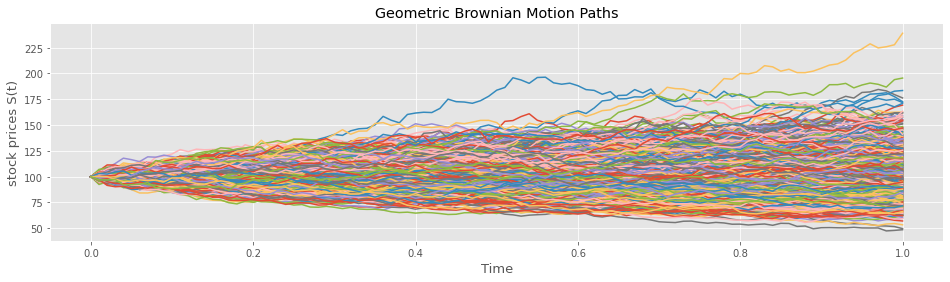

In [4]:
gbm_paths =  geometric_BM_paths(1000, 100, 0, 1, 0.025, 0.2, 100)
plt.plot(gbm_paths['time'], gbm_paths['paths'].T)
plt.xlabel('Time', fontsize=13)
plt.ylabel('stock prices S(t)', fontsize=13)
plt.title('Geometric Brownian Motion Paths')
plt.show()



### Black-Sholes (BS) formula for European call and put option

We build the help function to calculate the call and put price formula at maturity with the BS's closed form solution 

In [5]:
class option_type(enum.Enum):
    Call = "C"
    Put = "P"
    

In [6]:
def call_put_option_BS(is_option, S_0, K, r, sigma, t, T):
    
    K = np.array(K).reshape([len(K), 1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    
    if is_option == option_type.Call:
        option_price = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
    elif is_option == option_type.Put:
        option_price = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1) * S_0
        
    return option_price
        

#### Chosen parameters

In [7]:
S_0 = 100 # initial asset price
K = [110, 100, 90] # the strike price [OTM, ATM, ITM]
r = 0.05  # chosen risk-free interest rate
sigma = 0.2 # asset volatility
T = 0.5 # time to maturity 
t = 0.0 # initial time

#### True value of the BS formula

In [8]:
Bs_call_price = call_put_option_BS(option_type.Call, S_0, K, r, sigma, t, T)
#Bs_call_price
print("True solution of an OTM ATM ITM call option:\n", Bs_call_price)

True solution of an OTM ATM ITM call option:
 [[ 2.90647132]
 [ 6.88872858]
 [13.49851748]]


### Black-Scholes European Call Price with Monte Carlo approach

In [9]:
def BS_call_put_option_pricing_Monte_Carlo(is_option, S_0, K, r, t, T, num_paths, num_steps): 
    
    paths = geometric_BM_paths(num_paths, num_steps, t, T, r, sigma, S_0)
    
    ST = gbm_paths['paths'][:, -1]
    
    time = gbm_paths['time']
    
    if is_option == option_type.Call:
        call_payoff = np.maximum(ST - K, 0)
        mc_price = np.exp(-r * (T-t))*(np.sum(call_payoff) / num_paths)
    elif is_option == option_type.Put:
        put_payoff = np.maximum(K - ST, 0)
        mc_price = np.exp(-r * (T-t))*(np.sum(put_payoff) / num_paths)
        
    return mc_price
    

### Chosen Parameters

In [10]:
S_0 = 100 # initial asset price
K = 110 # the strike price
r = 0.05  # chosen risk-free interest rate
sigma = 0.2 # asset volatility
T = 0.5 # time to maturity 
t = 0.0 # initial time
num_paths = 2000
num_steps = 1000

### Compare: Estimation   vs  True value

In [11]:
mc_call_price = BS_call_put_option_pricing_Monte_Carlo(option_type.Call, S_0, K, r, t, T, num_paths, num_steps)
true_call_price = call_put_option_BS(option_type.Call, S_0, [K], r, sigma, t, T)

print(f"Monte Carlo Call price: {np.round(mc_call_price, 3)}")
print(f"True Call price: {np.round(true_call_price[0][0], 3)}")



Monte Carlo Call price: 2.721
True Call price: 2.906


### Convergence

In [12]:
num_paths_list = np.arange(10, num_paths + 10 , 10)
mc_call_prices = [BS_call_put_option_pricing_Monte_Carlo(option_type.Call, S_0, K, r, t, T, num_paths, num_steps) for num_paths in num_paths_list]

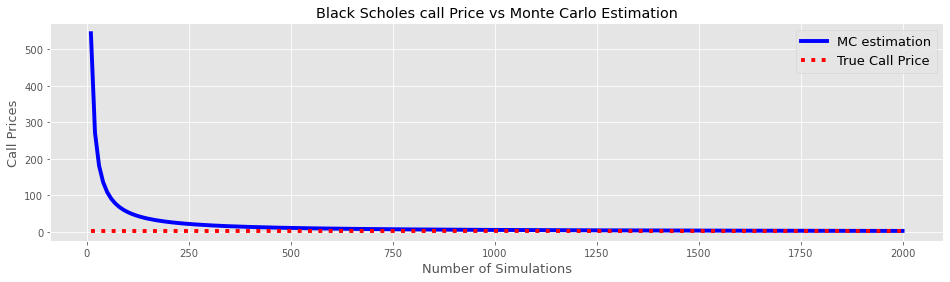

In [13]:
plt.plot(num_paths_list, mc_call_prices, color='b', linewidth = 3.9, label='MC estimation')
plt.plot(num_paths_list, [np.round(true_call_price[0][0], 3)]*len(num_paths_list), linewidth = 3.9, linestyle = 'dotted', color='r', label='True Call Price')
plt.legend(fontsize=13)
plt.title("Black Scholes call Price vs Monte Carlo Estimation")
plt.xlabel("Number of Simulations", fontsize=13)
plt.ylabel("Call Prices", fontsize=13)
plt.show()